# 1. 환경 준비
- Batch size, Epoch 등 변경 가능.

In [1]:
import time
start_time = time.time()   # 시작 시간 기록

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import AveragePooling2D  
from keras.layers import LeakyReLU
import cv2
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 파라미터
# 2. 데이터 준비
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
IMAGE_SIZE = [180, 180]   # X-ray image size
BATCH_SIZE = 32   # 한 번에 몇 개씩 훈련시킬 것인가.
# 기타: prepare_for_training에 augment 적용할 것인가.

# 4. CNN 모델링
mid_activation = 'relu'
convolution_filter_1 = 32
convolution_filter_2 = 64
convolution_filter_3 = 128
convolution_filter_4 = 256
dropout_rate_1 = 0.2
dropout_rate_2 = 0.7
dropout_rate_3 = 0.5
dropout_rate_4 = 0.3
final_activation = 'sigmoid'
conv_activation = mid_activation
dense_activation = mid_activation
channels = 16
# 기타: BatchNormalzation 사용 유/무

# 5. 데이터 불균형 처리
# Weight 적용 여부

# 6. 모델 훈련
learning_rate = 0.001  # 각 시도간 간격은 어떻게 조정할 것인가.
optimizer_adam = tf.keras.optimizers.Adam(lr=learning_rate)# learning rate가 원본 코드 상에는 없어 따로 뽑아냄.
EPOCHS = 20  # 훈련을 몇 회 시도할 것인가. 고정.

In [3]:
# data location
ROOT_PATH = r'C:\Users\user\Desktop\AIFFEL\Day26'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train/test/val 파일 개수 확인')
print('train:', len(train_filenames))
print('test:', len(test_filenames))
print('val:', len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('조정된 train/val 파일 개수 확인')
print('train:', len(train_filenames))
print('val:', len(val_filenames))

C:\Users\user\Desktop\AIFFEL\Day26
train/test/val 파일 개수 확인
train: 5216
test: 624
val: 16
조정된 train/val 파일 개수 확인
train: 4185
val: 1047


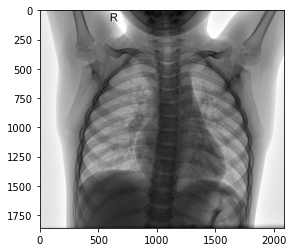

In [4]:
# 이미지 반전만
all_filenames = tf.io.gfile.glob(TRAIN_PATH)
all_filenames.extend(tf.io.gfile.glob(TEST_PATH))
all_filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 이미지 리스트 생성
inv_images = []

for i in range(len(all_filenames)):
    
    # 파일경로에서 이미지 불러오기
    temp_image = cv2.imread(all_filenames[i])
    
    # 이미지 가장자리 비율별 크롭. 여기서는 20%. 적용하지 않음.
    #crop_temp_image = temp_image[round(len(temp_image[0])*0.2):round(len(temp_image[0])*0.8), round(len(temp_image[1])*0.2):round(len(temp_image[1])*0.8)]
    
    # 이미지 반전.
    inv_temp_image = cv2.bitwise_not(temp_image)
    
    # 작업한 이미지를 이미지 리스트에 추가
    inv_images.append(inv_temp_image)

    # 작업한 이미지를 파일에 저장
    cv2.imwrite(all_filenames[i], inv_temp_image)

# 작업 예시 확인
plt.imshow(inv_images[0])
plt.show()

In [5]:
# train data 안의 정상 이미지와 폐렴 이미지 개수
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
C:\Users\user\Desktop\AIFFEL\Day26\chest_xray\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
C:\Users\user\Desktop\AIFFEL\Day26\chest_xray\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'Normal images count in training set: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
# tf.data 인스턴스화. tf에서 학습시킬 때 mini-batch로 작업할 수 있도록 해준다.
# 형태 확인은 train_list_ds.element_spec. 현재는 TensorSpec(shape=(), dtype=tf.string, name=None)
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# 데이터의 중복도를 확인하여 numpy 배열로 입력.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## 중간 회고

### (1) 판별 기준 검토
- 작업 전 판별 기준을 검토해 보았다.
- 임상에서 폐렴의 영상 진단 기준을 검색하여, 대한내과학회지의 '호흡기질환의 영상진단 Chest X-ray 중심으로'라는 글에서 다음과 같은 기준을 확인하였다.
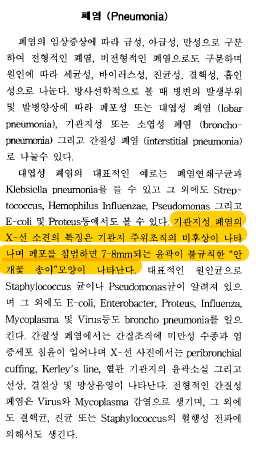

- 자료에서, 정상으로 라벨된 예시 이미지는 아래와 같다.
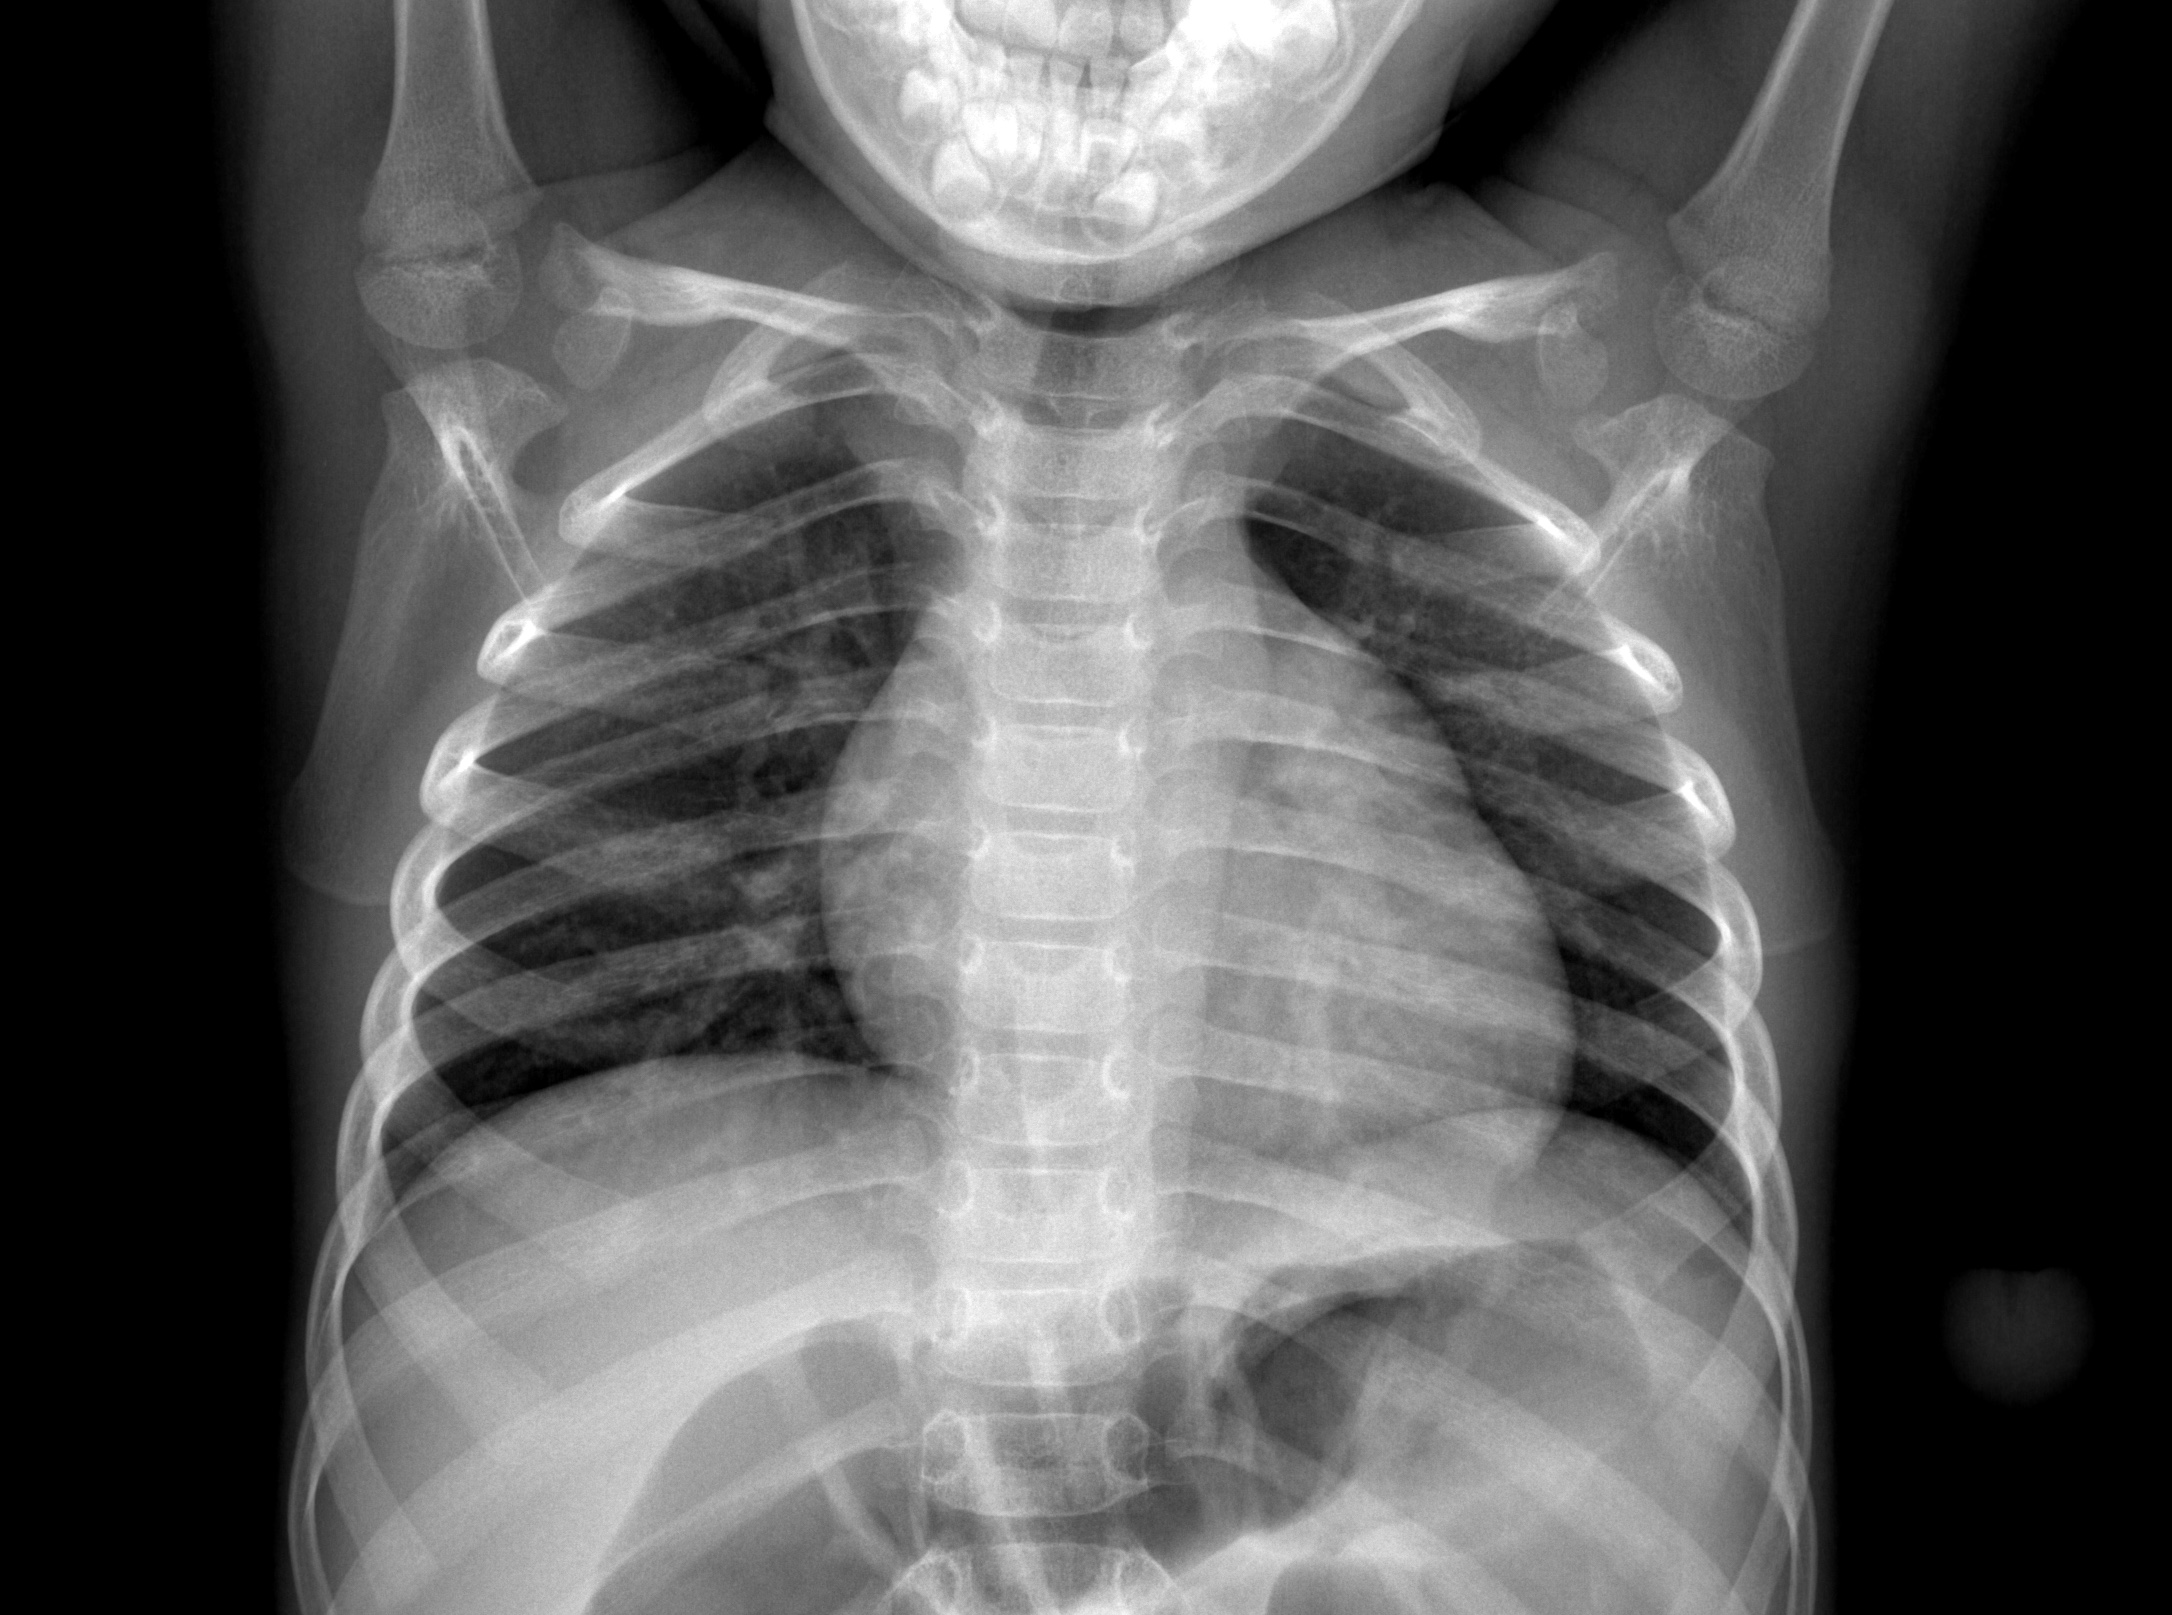

- 자료에서, 폐렴으로 라벨된 예시 이미지는 아래와 같다.
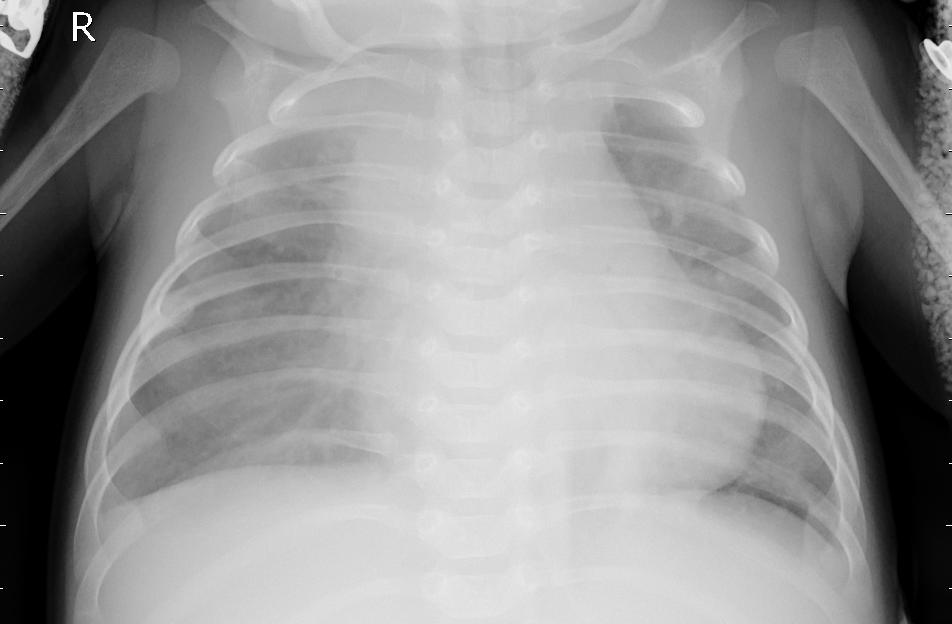

- 폐렴 모델은 위와 같이 안개꽃 송이 같은 모양이 폐 전체에 걸쳐 보이고 있다. 정상 폐는 희끗희끗한 것이 적고 좀 더 어두운데 비해 염증 폐는 희끗희끗한 것이 더 많다. 
- 단순화하면, 폐의 영역에서 검은색을 기준으로 하여 얼마나 희끗해졌는지를 판단하는 것이다. 그런데, 염증 이외에도 뼈나 장기들(심장, 간 등) 역시도 하얗게 보이고 있다. 이것이 염증 모델을 구분하는데 방해되지 않을까? 하는 생각이 들었다. 
- 그리고 MaxPooling의 특징은 특정 영역 내에서 가장 큰 값만을 뽑아내는 것이다. 흑백 모델에서는 더 하얀 부분을 추출한다는 뜻인데, 이 말은 해당 영역에 폐와 염증, 뼈, 장기 등이 같이 들어있는 경우 후자가 추출되고 폐는 누락된다는 말이다. 하얀 것이 염증인지, 뼈인지, 장기인지를 지정하는 알고리즘은 삽입되지 않았으므로, 이 진단방식은 적절하지 않을 가능성이 높다고 생각했다.
- 그래서 차라리 폐의 검은 부분이 얼마나 더 많이 있는가?를 새로운 진단 기준으로 삼고자 하였다. 그런데 폐는 더 어둡기 때문에 MaxPooling에서 누락된다. MinPooling이 필요하다. 하지만 검색결과 MinPooling이 별도의 모듈로 존재하는지는 확인하지 못했다. 그래서, 이미지를 반전시킬 방법을 연구했다.
- exploration 7번에서 했던 인물사진 편집에서, cv2.bitwise의 세부옵션에는 NOT이 있었는데 이것이 반전 코드이다. 이걸 적용하고 싶었는데 기본 코드내에서는 이미지가 tf.data로 감싸인다. 그 구조는 아래 그림과 같다.
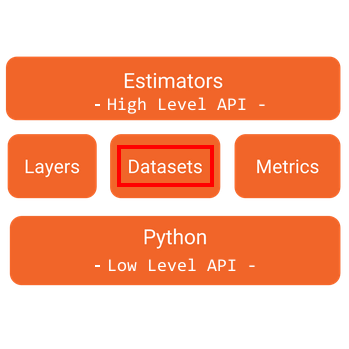

- 따라서 이 상태에서 반전을 시킬 수는 없다. decode_img()에서 적용해보고자 이런 저런 애를 썼으나 실패. 게터같은 함수가 필요할 것으로 생각된다. 조 내에서 질문을 해본 결과 take()를 이용해보는게 어떻겠냐는 답이 있었다. 하지만 생각해보니 수정 후 다시 삽입하려면 세터에 해당하는 함수도 필요하다. 이것까지는 찾지 못해서 내부 수정은 포기하고, tf.data 적용 전에 수행하여 반전을 확인하였다. 아래 그림은 정상 모델의 반전 예시다.
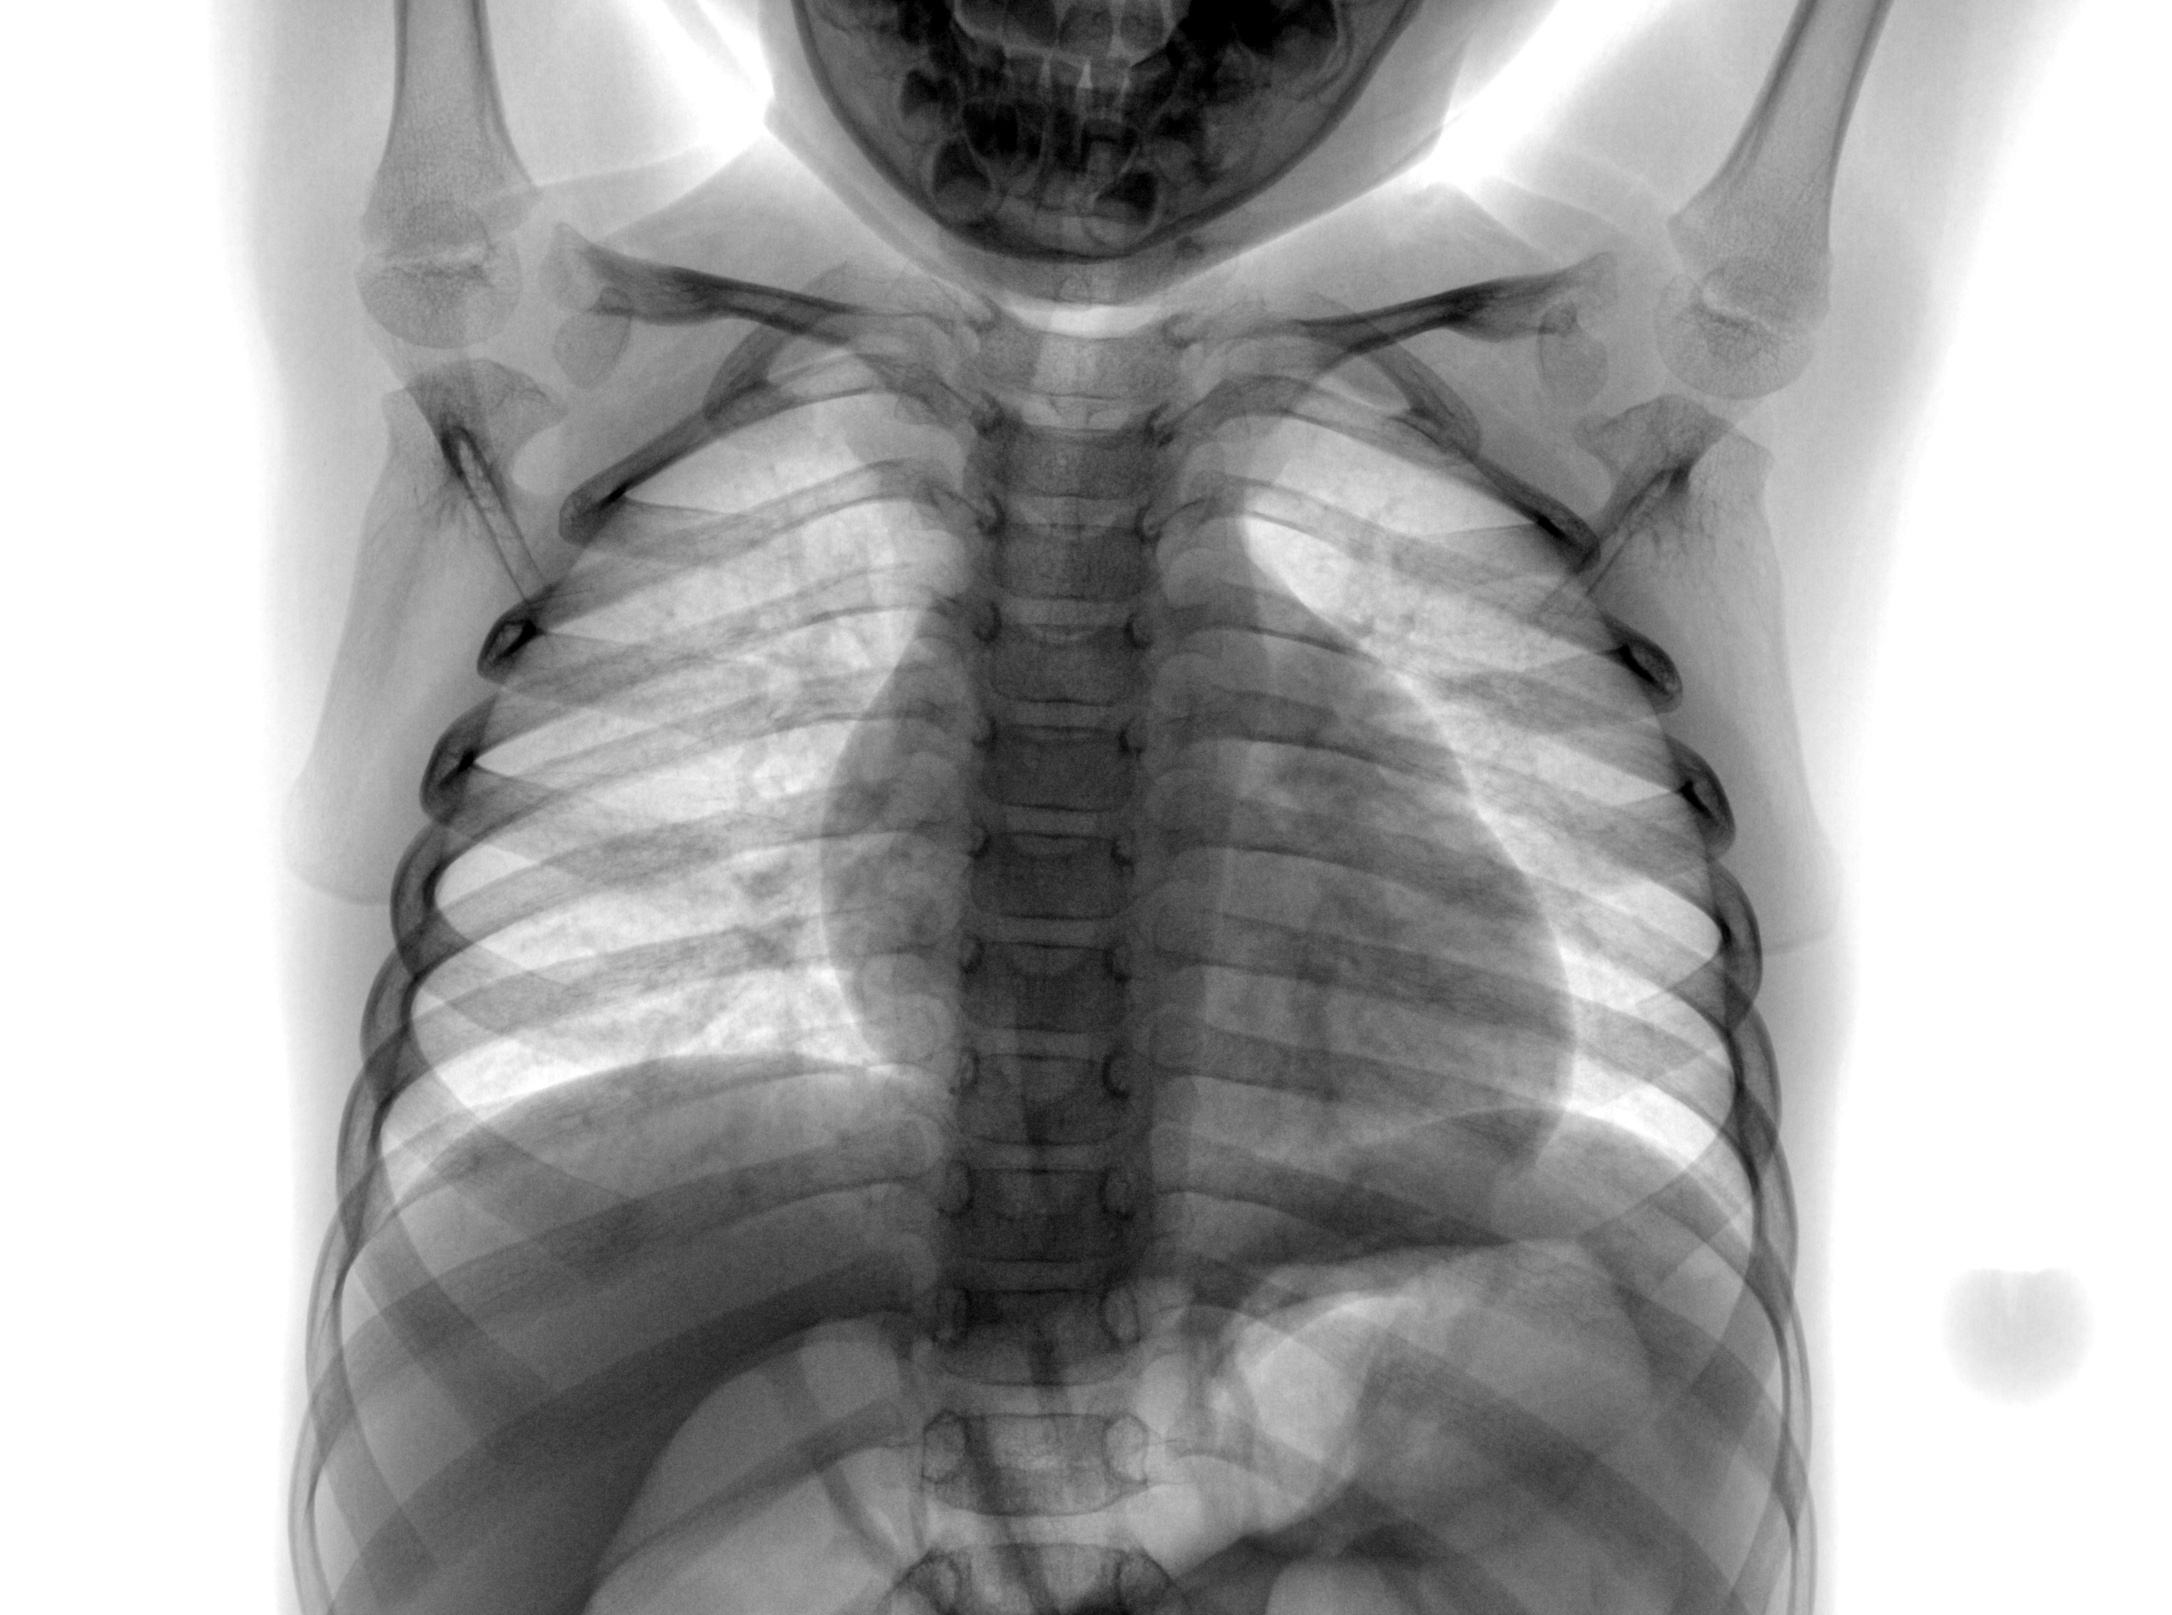

- 추가로, 검은 색을 판단하고자 하는데 배경의 검은색이 이미지에 포함된다면 혼동을 줄 수 있다고 생각하여 가장자리를 잘라내는 방법을 생각하였다. 이미지의 상하좌우 20%씩을 잘라내고자 했는데, cv2에서의 크롭방법인 리스트 내의 구간 설정을 할 때 비율로 하는 방법을 decode_img()에 삽입하는 것은 위와 같은 이유로 불가하였다. 그래서 이 역시 tf.data 적용 전에 수행하였다. 정상 모델의 크롭 예시다.
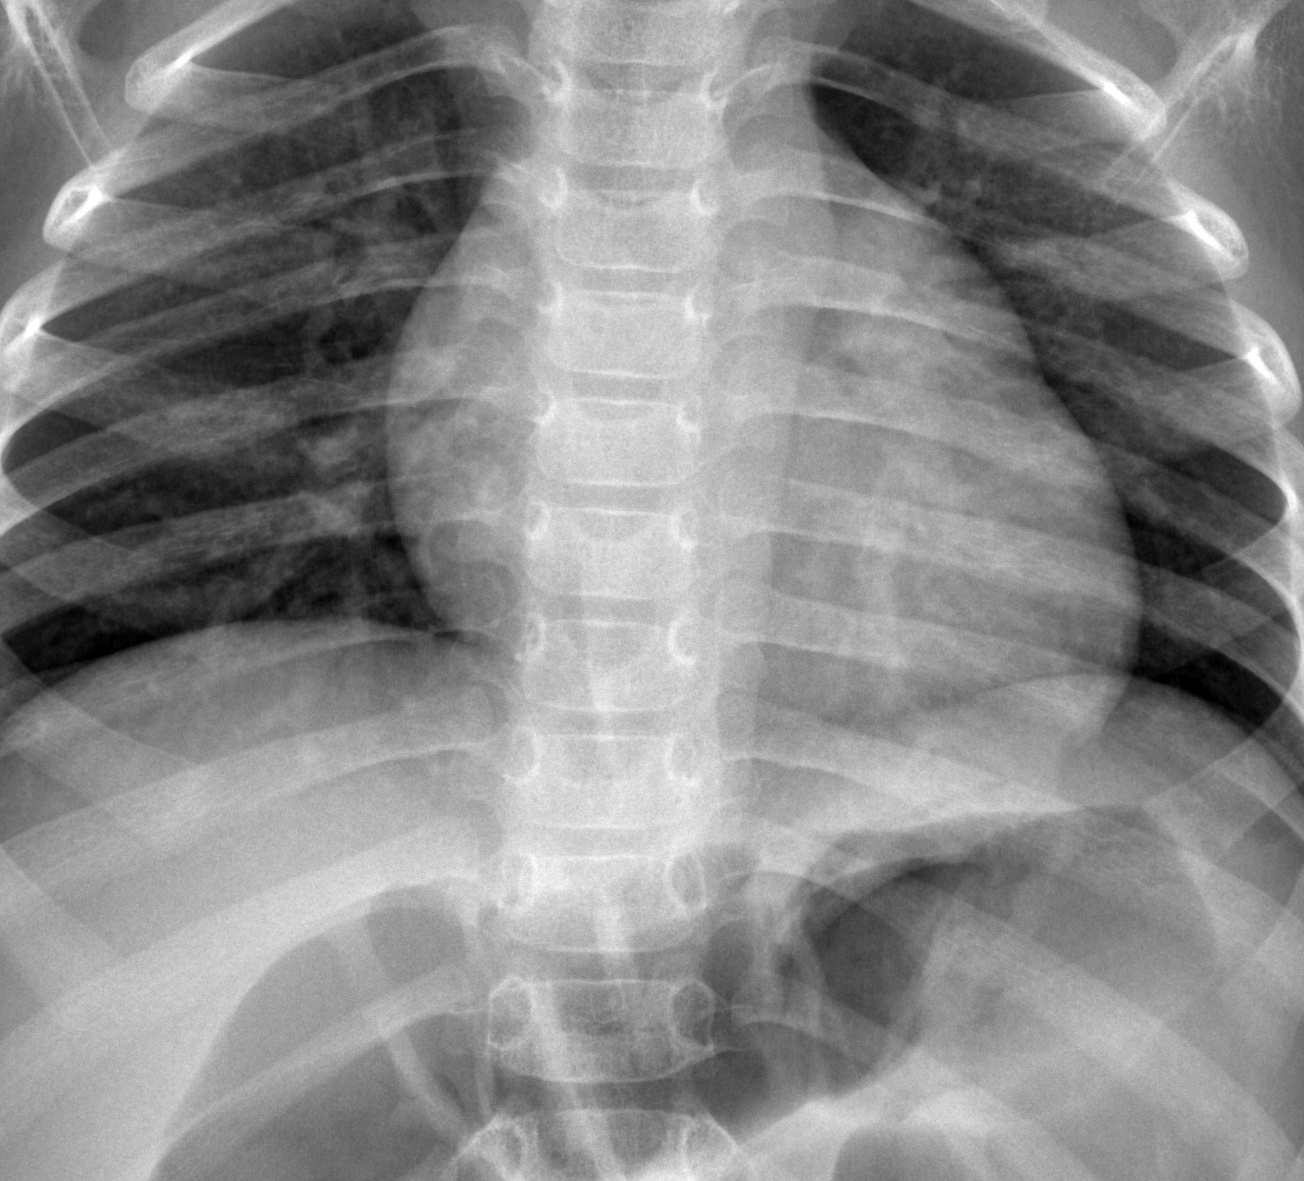

- 반전과 크롭을 동시에 적용한 이미지도 만들었다. 정상 모델의 반전+크롭 예시는 아래와 같다.
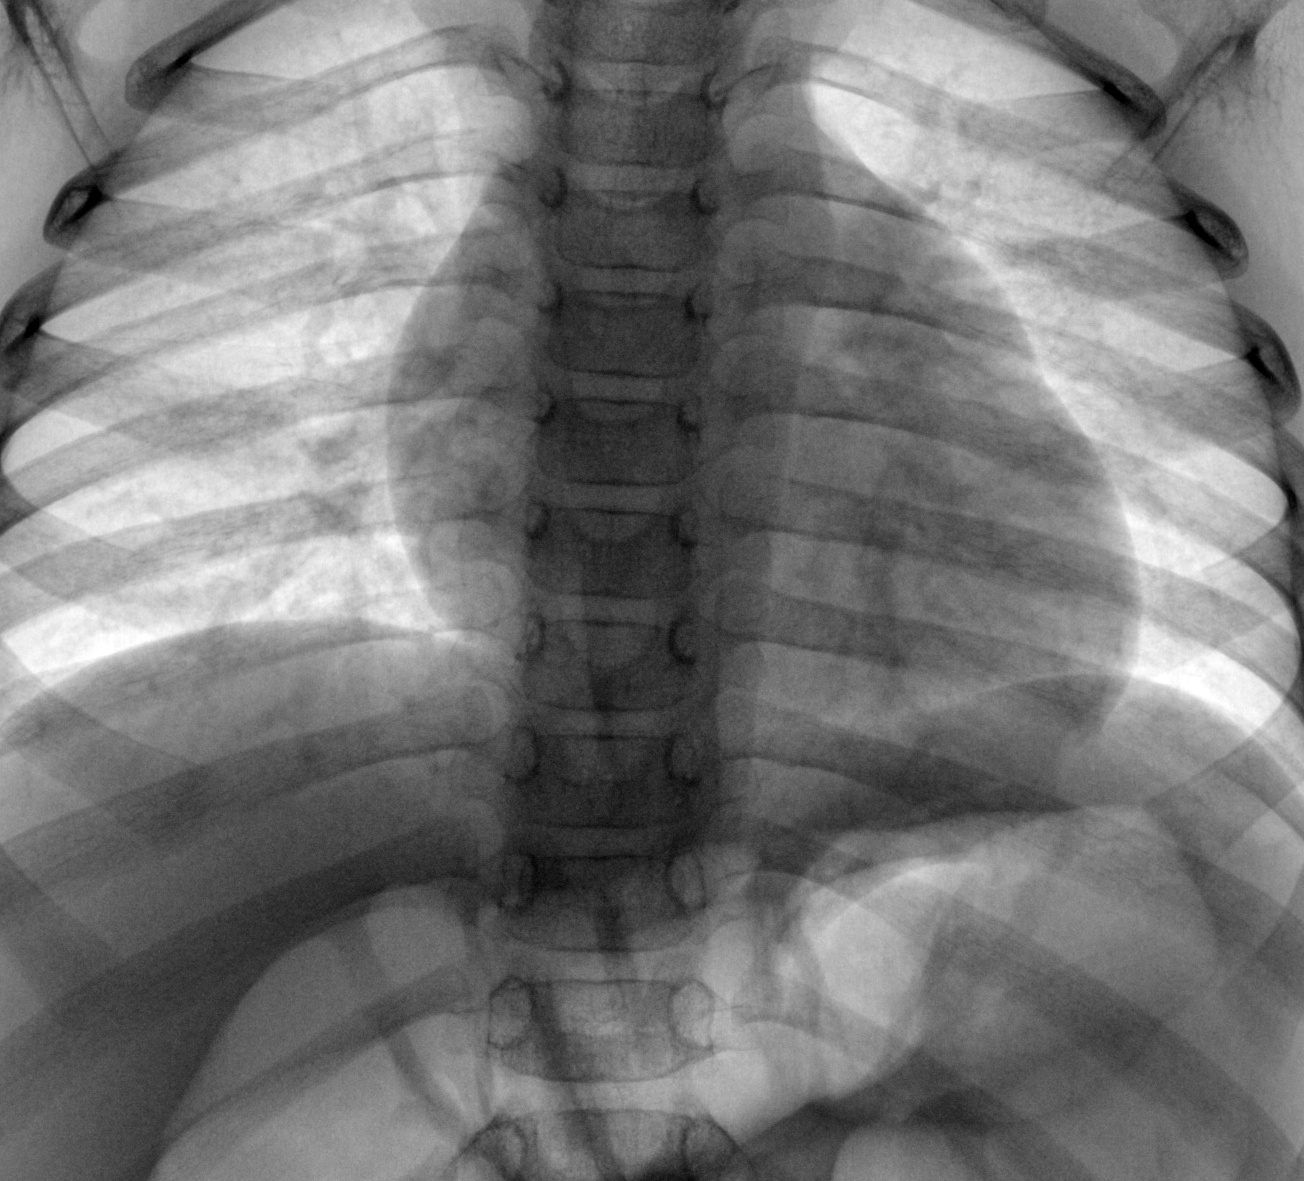
- 이렇게 원본에 대해서는 원본/반전/20%크롭/반전+20%크롭 4가지 버전에 대해, 초기 파라미터 설정대로 수행하여 그 영향을 먼저 점검하기로 했다.

# 2. 데이터 준비
- 육안으로 구분하기 어려운 미묘한 차이에 노이즈 등의 부수효과가 방해를 줄 수 있으므로 augmentation 도입은 신중하자.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"    # 폐렴이면 양성(True), 노말이면 음성(False)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3)     # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)     # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)      # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)   # 이미지 읽기
    img = decode_img(img)    # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
# train dataset과 valdiation dataset을 만듬. AUTOTUNE 변수를 사용하면 더 빠르게 처리.
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

for image, label in train_ds.take(1):
    print('Image shape:', image.numpy().shape)
    print('label:', label.numpy())

Image shape: (180, 180, 3)
label: False


In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    return image, label

def prepare_for_training(ds, shuffle_buffer_size = 1000):
    
    # augment 적용 부분이 배치처리 함수에 추가.
    #ds = ds.map(augment, num_parallel_calls = 2)
    
    # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  
    
    # epoch를 진행하면서 여러 번 데이터셋을 불러와도 사용할 수 있게 해줌.
    ds = ds.repeat()
    
    # BATCH_SIZE에서 정한 만큼의 배치로 주어짐.
    ds = ds.batch(BATCH_SIZE)
    
    # 학습데이터를 나눠서 읽음. 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 중간 회고
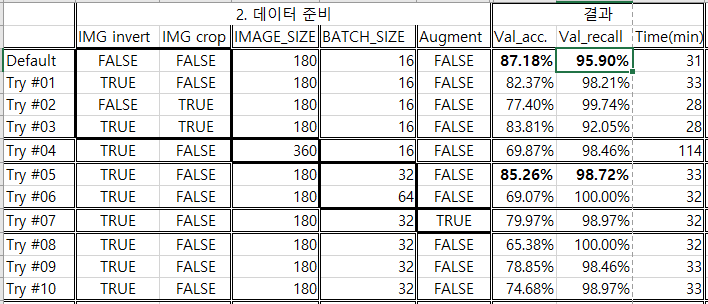
### (1) 이미지 반전, 이미지 크롭
- MaxPooling2D 적용시 폐를 부각하고자 이미지를 반전해 보았다.
- 폐 내부만 보면 되므로 배경을 잘라내고자 이미지의 상하좌우 가장자리를 각 20%씩 잘라내었다. 폐 내부도 다소 잘렸지만 내부만 보는 것이 더 중요하다고 생각했다.
- 이미지 반전 시 정확도 87.18% -> 82.37%, 리콜 95.90% -> 98.21%로 변화하였다. 정확도가 약 5% 떨어졌지만 리콜이 만족스러웠다. 이후 시행은 반전이미지를 채택하기로 하였다. 두 수치를 다 개선하고자 하는 것보다 하나를 확실히 확보하고 다른 것을 시도하는 것이 더 빠를 것이라고 판단했기 때문이다.
- 이미지 크롭 시 정확도는 87.18% -> 77.40%, 리콜 95.90% -> 99.74%로 변화하였다. 리콜은 만족스러웠으나 정확도가 약 10%나 떨어져서 채택을 망설이게 되었다. 
- 직전의 결과가 있어 반전과 크롭을 같이 적용해 보았다. 결과는 정확도 83.81%, 리콜 92.05%로, 정확도는 어느 정도 확보되었지만 리콜이 대폭 하락했다. 리콜이 만족스럽지 않아 크롭은 채택을 배제하였다. 
- 배경을 잘라냈을 때 정확도가 떨어진다는 말은 학습시 배경도 특징으로 잡는다는 것으로 해석된다. 사람은 폐만 보고 진단하지 배경을 보고 진단하지 않는다. 과연 배경도 보는 이 알고리즘의 진단을 신뢰할 수 있는가? I don't think so. 이후 과정을 모두 보고 최종 판단하기로 하였다.

### (2) IMAGE_SIZE
- 첫 과제인 가위바위보 판별에서도 경험했듯, 일반적으로 해상도가 증가하면 분석 품질은 증가하는 경향이 있다. 그래서 이미지 크기를 2배 늘려 (360,360)으로 놓아보았다.
- 결과는 정확도 69.87%, 리콜 98.46%가 나왔다. 
- 기본 값인 (180, 180)보다 좋지 않은데, 차원의 저주가 발생한 것인가? 더 올리거나 더 줄이면 어떻게 될까? 시간관계상 생략한다.
- feature point의 개수 증가가 추가로 필요할까? 이 파라미터가 명시되어 있지 않아 찾아야 한다. 시간관계상 시도해보지 못했다. 하지만 생각해볼 점으로 남겨둔다.
- 결과의 스윙폭이 커서 우연히 안 좋은 결과에 걸렸겠다는 생각도 든다. 시간관계상 재시도는 생략하였다.
- 180일 때 소요시간은 대략 30분 전후이나 360으로 증가시켰을 때 114분이 소요되었다. 다른 파라미터도 많이 남아 있으므로 이 부분에서 추가 실험은 하지 않고 이후 실험의 이미지 크기는 180으로 고정하였다.

### (3) BATCH_SIZE
- 데이터를 쪼개는 크기인 배치는 기본값 16외에 32, 64를 시도해 보았다.
- 32에서 정확도 82.37% -> 85.26%, 리콜 98.21% -> 98.72%가 나왔다. 64는 정확도 69.07%, 리콜 100%로 나왔다.
- 32에서 리콜도 조금 더 좋아졌을 뿐 아니라 정확도가 기준치 안에 들어왔으므로 이후 실험은 32를 채택하였다.
- 64에서 리콜이 100%로 완벽한 것은 주목할만하나 정확도가 10% 이상 미달되었다. 과도하게 거른 것이라고 볼 수 있다.
- 왜 32가 가장 적절하고 16, 64가 덜 좋은지에 대한 정확한 이유는 잘 모르겠다. 추가 공부가 필요하다.

### (4) augment()
- 다양한 학습을 위해 이미지의 일부를 무작위적으로 좌우 반전하였다.
- 결과는 정확도 79.97%, 리콜 98.97% 였다. 
- 정확도가 오히려 떨어져 그다지 좋은 개선 결과를 주지 못했다. 채택하지 않았다.
- 학습 데이터의 양이 몇 천장 정도는 부족하기 때문에 그럴 수도 있다는 생각도 든다. 실전에서는 좌우 반전이 얼마든지 있을 수 있다. 데이터의 양을 더욱 증가시킨 후 추가 시도를 해보아야 한다고 생각된다.

# 3. 데이터 시각화
- augmentation을 시도했다면 show_batch 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인.

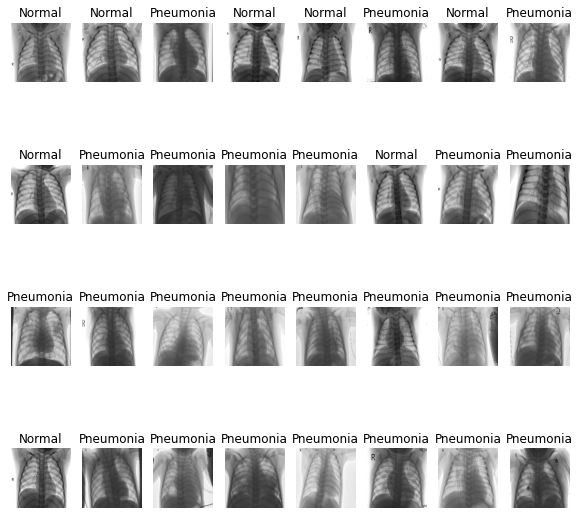

In [13]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줌.
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('Pneumonia')
        else: 
            plt.title('Normal')
        plt.axis('off')
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링
- Convolution filter, Channel number, activation, model structure 등 변경 시도.
- Batch normalization 사용 유/무
- Dropout 사용 유/무, 사용시 비율 변경.

In [14]:
# Convolution block
def conv_block(filters, conv_activation):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = conv_activation, padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = conv_activation, padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D()
    ])
    
    return block

# Dense block
def dense_block(units, dropout_rate, dense_activation):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = dense_activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [15]:
def build_model(channels, mid_activation, convolution_filter_1, convolution_filter_2, convolution_filter_3, convolution_filter_4, conv_activation, dense_activation, final_activation):
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(channels, 3, activation = mid_activation, padding = 'same'),
        tf.keras.layers.Conv2D(channels, 3, activation = mid_activation, padding = 'same'),
        tf.keras.layers.MaxPooling2D(),
        
        conv_block(convolution_filter_1, conv_activation),
        conv_block(convolution_filter_2, conv_activation),
        
        conv_block(convolution_filter_3, conv_activation),
        tf.keras.layers.Dropout(dropout_rate_1),
        
        conv_block(convolution_filter_4, conv_activation),
        tf.keras.layers.Dropout(dropout_rate_1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, dropout_rate_2, dense_activation),
        dense_block(128, dropout_rate_3, dense_activation),
        dense_block(64, dropout_rate_4, dense_activation),
        
        tf.keras.layers.Dense(1, activation = final_activation)
    ])
    
    return model

## 중간 회고
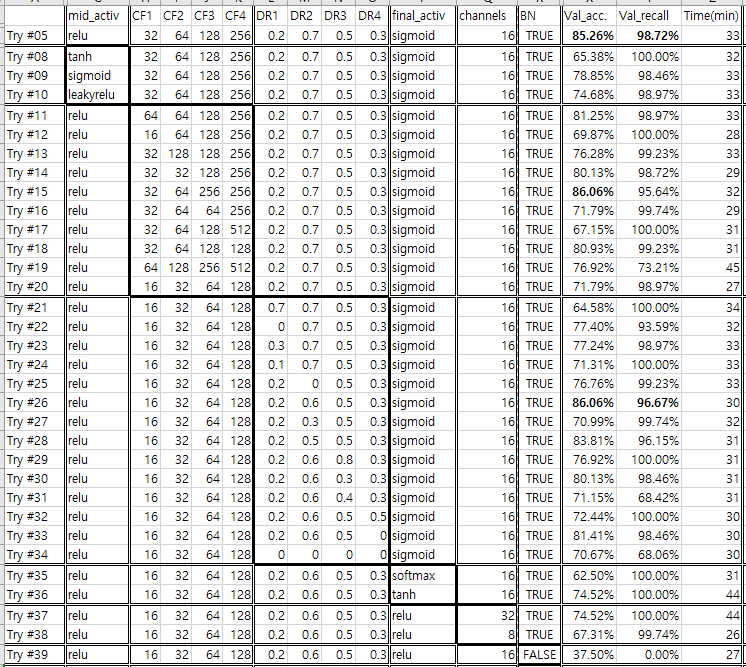


### (1) mid_activation
- conv_block()과 dense_block()의 활성함수를 mid_activation으로 놓고 기본 relu 이외에 tanh, sigmoid, leakyrelu 등을 적용해 보았다. 정확도는 모두 80%아래로 하락하였다.
- tanh 적용시의 정확도는 65% 가량으로 특히 낮았다. 0 근처에는 입력값이 많지 않지 않음을 시사하는 것으로 생각된다. 
- sigmoid 적용시의 정확도는 78% 가량으로서 tanh 적용시 보다 좋다. 이는 입력값이 양수쪽에 더 많다는 것으로 해석된다. relu가 음수 입력값에서의 미분값이 0임을 생각해보면 이해는 합치한다. 
- leakyrelu 적용시의 정확도는 relu대비 음수 입력값에 대해 퍼포먼스가 훨씬 더 좋을 것으로 기대하였으나, 결과는 74%가량으로 sigmoid 적용시보다 더 낮았다. 앞의 입력함수들의 적용결과를 해석한 내용과 일관적이지 않아 고개를 갸우뚱하게 되었다. 
- ELU, MAXOUT 등을 적용해보고 이를 추가 해석하고 싶었으나 코드를 찾지 못해 시도해보지는 못했다. 추후 이슈가 있으면 해봐야겠다.

### (2) convolution_filter(CF)
- build_model()의 4개 conv_block()에 들어가는 필터들의 숫자를 조정한 후 정확도를 비교해 보았다.
- 하나씩 올리거나 내려도, 모두 올리거나 내려도 대부분 기본값 적용시보다 낮은 결과가 나왔다.
- CF3번 적용 시 예외적으로 정확도 86.06%가 나왔으나 이 때의 리콜은 95.64%여서 적용하지 않았다. 
- 기본 설정값이 최적이라는 결론이다. 의미 단위가 이 수준에서 적절했던 것으로 보인다.

### (3) dropout_rate(DR)
- build_model()의 tf.keras.layers.Dropout() 및 dense_block()의 dropout_rate를 조정해 보았다.
- CF의 경우와 마찬가지로 하나씩 올리거나 내려도, 모두 올리거나 내려도 대부분 기본값 적용시보다 낮은 결과가 나왔다.
- DR2번에 대해 0.7 -> 0.6 적용시 정확도가 85.26% -> 86.06%로 증가했다. 하지만 리콜이 98.72% -> 96.67%여서 고민하다가 채택하기로 결정하였다. 이후 실험은 DR2 = 0.6으로 진행하였다.
- DR 설정값 역시 기본이 최적이라는 결론이다. 하지만 어떤 메커니즘으로 과적합방지가 적용되는지는 아직 잘 모르므로, 이후 추가 공부가 필요하다.

### (4) channels
- build_model()의 tf.keras.layers.Conv2D()의 채널을 조정해 보았다.
- 올리거나 내려도 모두 기본값 적용시보다 낮은 결과가 나왔다.
- 기본값이 최적값이라는 말이 되는데 그 이유는 잘 모르겠다. 추가 공부가 필요하다.

### (5) BatchNormalization(BN)
- conv_block()의 tf.keras.layers.BatchNormalization()을 주석처리하여 제외해 보았다.
- 적용 제외시, 정확도는 37.5%로 가장 낮았으며 리콜은 무려 0%가 나왔다. 
- 배치 정규화의 절대적인 영향력을 여실히 드러내고 있다.
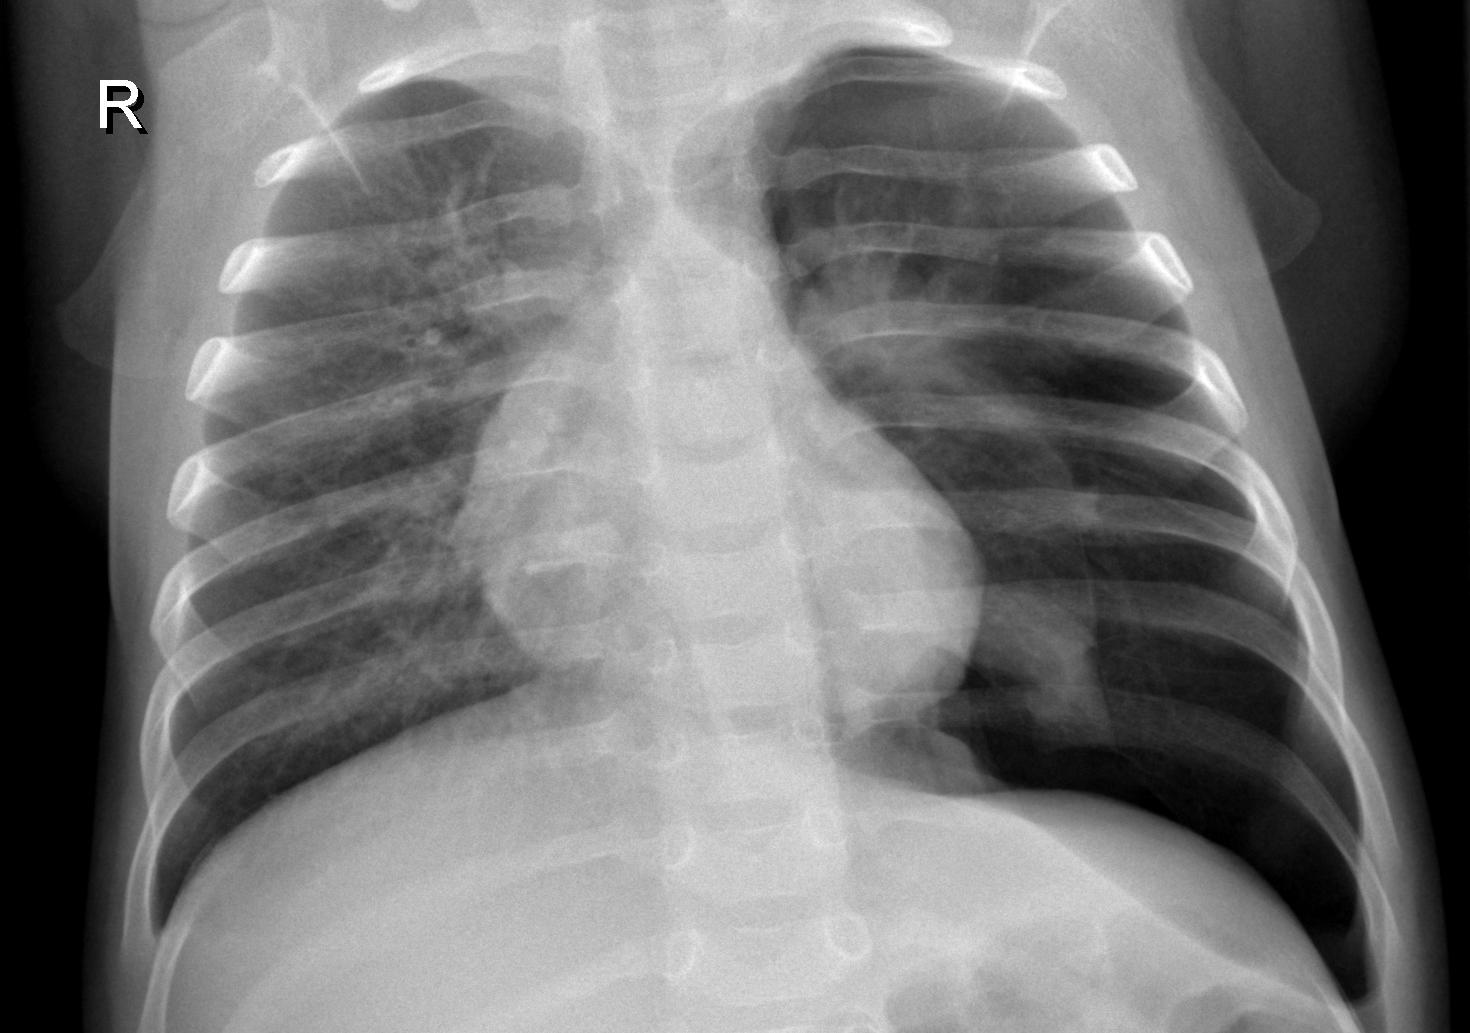

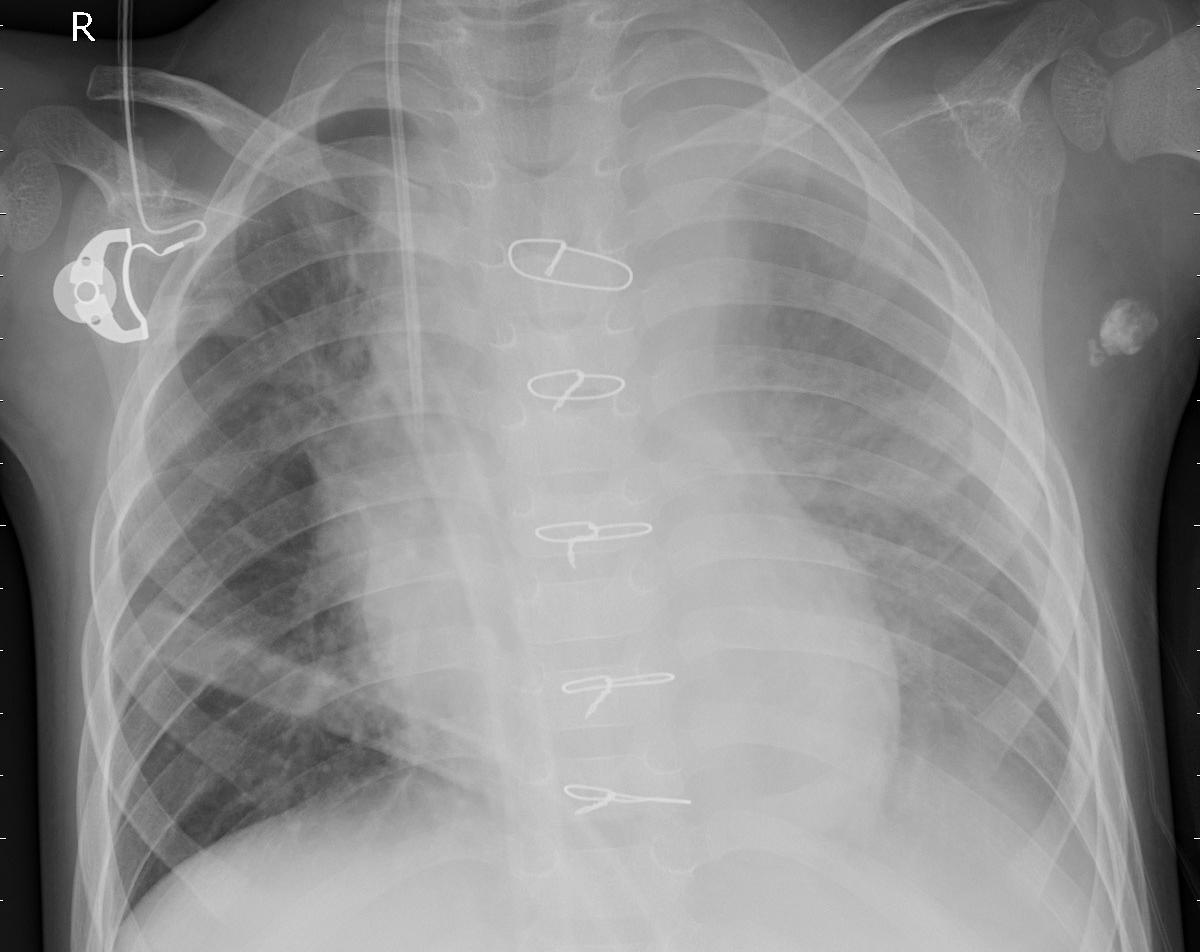
- 위의 그림은 둘 모두 폐렴 모델인데, 염증의 분포에 따라 밝기 대비에 차이가 나는 데이터들이 존재한다. 
- 위 두 이미지에 대해 BN을 적용하기 전 후의 히스토그램을 관찰해보면, BN이 어떤 일을 하는지 정확히 알 수 있을거라 생각한다. 
- 하지만 tf.data로 덮인 이미지를 뽑아내는 방법을 아직 찾지 못했다. take()를 사용하면 될 것 같다는 단서를 얻었지만, 수정 후 재삽입하는 방법을 찾지 못했다. 꺼내기만 하는 것은 의미가 없으므로 시간 관계상 다음 번에 하기로 하고 생략하였다.

# 5. 데이터 불균형 처리
- class_weight를 생략하면 어떻게 될까?
- recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 강화하는 효과를 만들어낼 수는 없는가?

In [16]:
# Weight control
weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 중간 회고
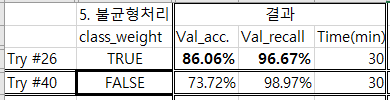

### (1) class_weight(CW)
- 가중치 적용은 model.fit()의 class_weight에 되었다.
- CW 적용을 제거하자 정확도가 86.06% -> 73.72%로 상당히 하락하는 것을 확인할 수 있었다.
- 가중치의 영향을 많이 받는다는 것은 확인하였는데, 어째서 이 정도로 많이 받는지는 의문사항이다. 나라면, 혹은 일반화해서 사람이라면 몇천장 정도 보면 그 이후는 큰 차이가 없을 것 같다는 생각이 드는데 말이다. 추가 공부가 필요하다고 본다.

### (2) 리콜을 강조하기 위해 폐렴 데이터를 잘 맞추는 것
- 앞서 데이터 준비단계의 이미지 반전/크롭 시도를 통해 확인하였다. 여기서는 생략.

# 6. 모델 훈련
- 손실 함수 변경은 어렵겠지만 optimizer나 learning rate 등의 변화를 고려.

In [17]:
with tf.device('/GPU:0'):
    model = build_model(channels, mid_activation, convolution_filter_1, convolution_filter_2, convolution_filter_3, 
                        convolution_filter_4, conv_activation, dense_activation, final_activation, )
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
    optimizer=optimizer_adam,
    loss = 'binary_crossentropy',
    metrics = METRICS)

In [18]:
with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    class_weight = class_weight,
    )

Epoch 1/20
130/130 [==============================] - 89s 643ms/step - loss: 0.4083 - accuracy: 0.7911 - precision: 0.9498 - recall: 0.7591 - val_loss: 0.6212 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 82s 627ms/step - loss: 0.2132 - accuracy: 0.9159 - precision: 0.9774 - recall: 0.9081 - val_loss: 0.7725 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 82s 628ms/step - loss: 0.1726 - accuracy: 0.9365 - precision: 0.9780 - recall: 0.9356 - val_loss: 0.9337 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 82s 631ms/step - loss: 0.1406 - accuracy: 0.9519 - precision: 0.9872 - recall: 0.9476 - val_loss: 1.2134 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 82s 628ms/step - loss: 0.1443 - accura

## 중간 회고
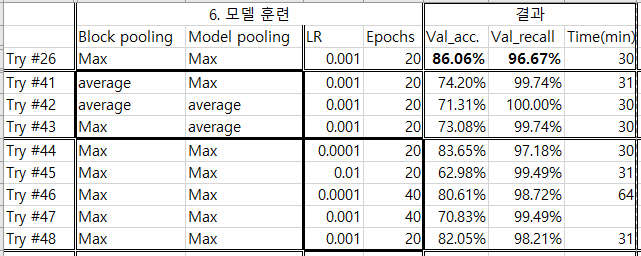

### (1) Pooling
- conv_block()과 build_model()에서 Maxpooling2D()에 대해 각각 혹은 모두 Averagepooling2D로 바꿔가며 시도해 보았다.
- 기본 설정인 Maxpooling에서 결과가 가장 좋았다. 각 부위의 차이를 감지하여야 하는 분석목적을 생각해보면 차이를 상쇄하는 평균화가 적절하지 않은 것은 당연하다고 생각된다.

### (2) learning_rate(LR), EPOCHS(EP)
- LR은 기본 코드에서 명시되어 있지 않다. 이리저리 찾다가 optimizer의 기본설정값 'adam'을 tf.keras.optimizers.Adam으로 바꾸면 세부 옵션으로 LR을 넣을 수 있음을 확인하고 optimizer를 수정하고 이를 삽입했다.
- 위의 기타 파라미터 테스트에서 LR 기본값은 0.001, EP 기본값은 20으로 놓고 수행하였다. 
- LR, EP의 변경은 결과를 개선하지 못했고 정확도는 오히려 떨어졌다. 학습과정에서의 정확도 격차(스윙)도 계속 발견되어 안정성도 확보되지 않았다고 생각된다. 최종 회고에서 추가 기술하고자 한다.

# 7. 결과 확인과 시각화
- Accuracy 뿐아니라 Recall도 중요.

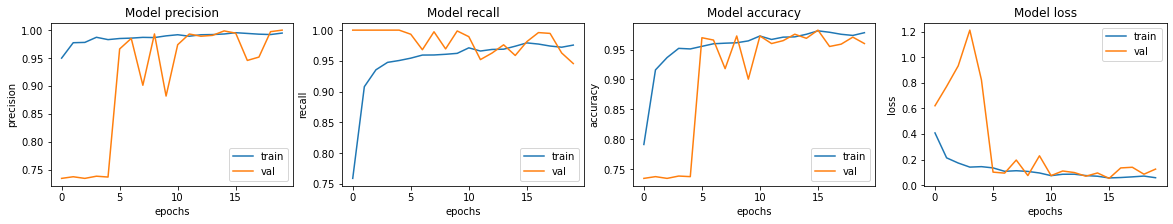

In [19]:
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \n Accuracy: {accuracy}, \n Precision: {precision}, \n Recall: {recall}')
complete_time = time.time()   # 종료 시간 기록
print(f'이 프로세스의 총 소요시간은 약 {int((complete_time-start_time)//60)}분입니다.')

20/20 [==============================] - 4s 187ms/step - loss: 0.5970 - accuracy: 0.8429 - precision: 0.8080 - recall: 0.9821
Loss: 0.5969931483268738, 
 Accuracy: 0.8429487347602844, 
 Precision: 0.8080168962478638, 
 Recall: 0.9820512533187866
이 프로세스의 총 소요시간은 약 30분입니다.


# 최종 회고
## (1) 학습 안정성
- 지금까지의 결론에 다다르기까지 50회 이상 수행하였는데, 이렇게 나온 결과들을 신뢰할 수 없었다. 그 이유는 같은 조건이라도 시도 시기마다 다른 값이 나왔기 때문이다. 한 파라미터의 최대치와 다른 파라미터의 최소치가 서로 엇갈리는 결과가 도출될 수 있어 지금까지 시행한 결과들에 대한 해석이 무의미 할 수 있다. 예를 들면 이미지의 크기 이슈가 그러하다. 가위바위보에서는 해상도를 14 -> 28, 56, 112 등으로 증가시켰을 때 판별력이 증가함을 확인하였으나 여기서는 그렇지 않았다. 시간 관계상 360 픽셀 하나 밖에 보지 못해 섣부른 판단은 이르지만, 그래도 정확도가 정체도 아니고 오히려 줄었다는 것은 매우 의문스럽다. 어느 테스트던 재현이 되어야 확신할 수 있는 것 아닌가.
- 같은 맥락에서 LR, EP의 변경이 큰 도움이 되지 않았다. LR은 엑셀에는 모두 삽입하지 않았으나 0.01~0.00001 까지 시도해 보았는데 훈련시의 스윙은 개선되었지만 평가시의 스윙은 개선되지 않았다. EP역시 LR 일때 0.00001까지 늘려보았으나 역시 큰 도움은 되지 않았다. 
- LR이 영향이 없었던 이유를 추가로 생각해보면, 내가 찾은 optimizer에서의 LR 파라미터가 모델 전체에 적용되는 파라미터가 아닐 수 있다. 추가 조사가 필요하다.
- 파라미터를 바꿔가며 여러 번 시행해도 현재 코드 상에서 정확도는 85%가 재현되지 않았기 때문에 가장 양호했던 Try #5의 결과를 별도 첨부한다.
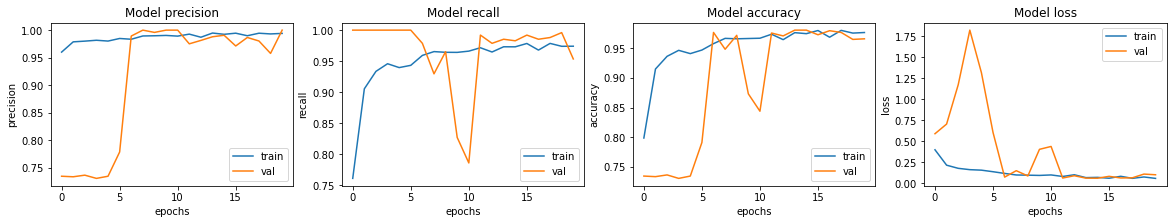

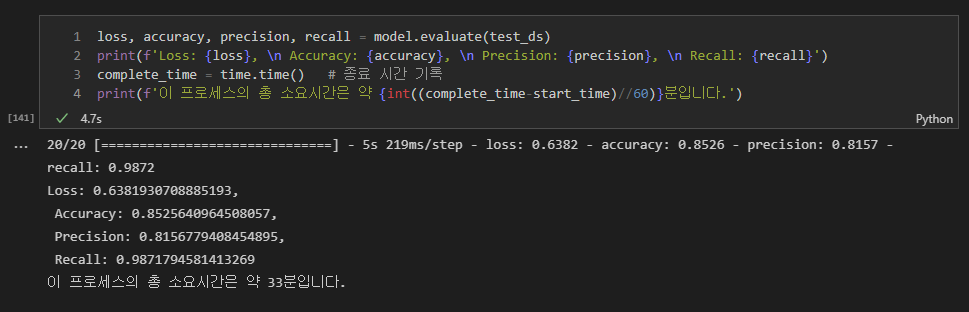
## (2) 학습 신뢰성
- 학습 안정성이 보장된다고 가정하더라도 이미지 크롭 결과에서 보았듯, 이미지의 가장자리를 잘라내면 학습의 효과가 떨어졌다. 사람은 가장자리를 보지 않는데, 컴퓨터는 본다는 말이다. 이 알고리즘에는 폐만 관심영역(Region of interest, ROI)으로 지정하는 내용이 없다. 
- 사람과 판단 기준이 다르다는 말이 무엇을 의미하는가? 사람과 다른 기준을 가지고 있는 알고리즘을 신뢰할 수 있는가? 엄밀하게 판단한다면, 임상의 관점에서 근거를 제시할 수 없는 진단은 실익이 없다고 생각한다. 이유를 설명할 수 없는 의사를 어떻게 환자가 믿고 위험부담이 있는 치료를 받을 수 있겠는가? 따라서 이 내용만 가지고 학습 결과를 신뢰할 수는 없다고 생각한다.

## (3) 평가 기준
- 과제 평가 기준은 정확도 85%이다. 실전을 생각하면, X-ray를 이용한 진단은 정확도보다 리콜의 중요성이 훨씬 높다. FP(False positive, 위양성)이 나온 환자는 추가 진단을 통해 사실여부를 판단할 수 있다. 예를 들면 CT가 그러하다. 아래 첨부 기사는 코로나 폐렴에 대한 X-ray 진단의 한계를 보여주고 있다.
- https://www.joongang.co.kr/article/23720884#home

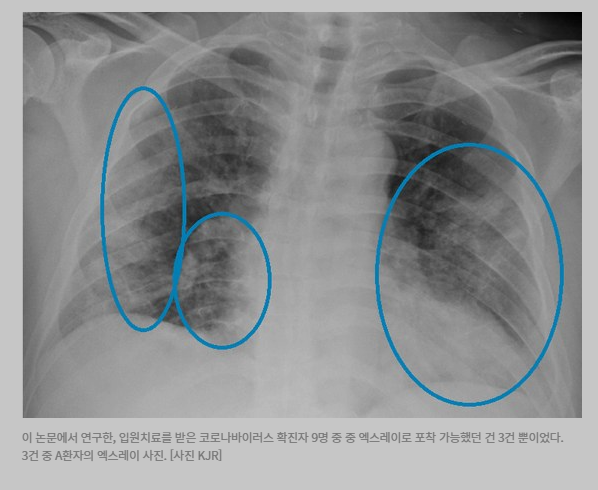

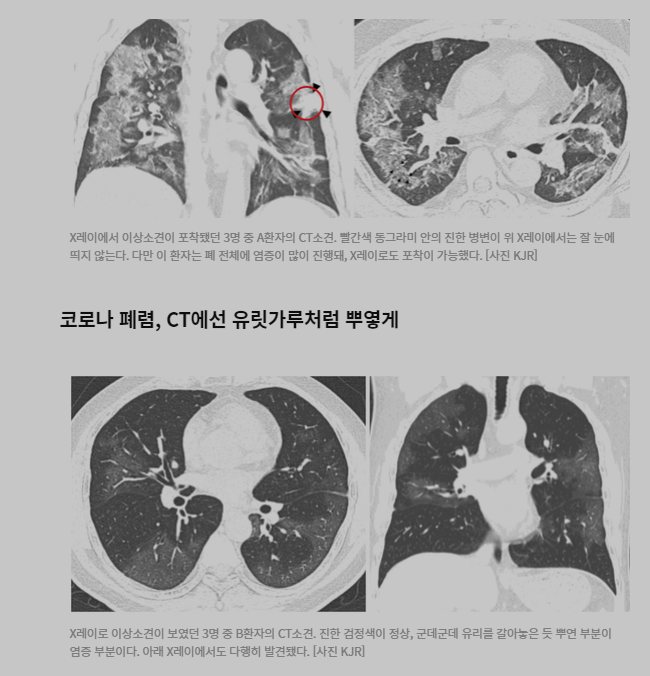

- X-ray는 단 한장만 찍기 때문에 염증을 정확히 진단하는데 한계가 있다. 염증은 하얗게 나오는데, 그 부위가 작고 또 뼈나 심장 등 장기에 가려지게 되는 환경에서는 아예 판별이 불가능하다. 따라서 X-ray는 이상한 낌새를 알아채는 정도면 족하다. 정확도가 85%면 좋지만, 반드시 85%이어야 할 필요는 없다고 생각한다. FP가 나오더라도 CT 촬영이나 혈액검사 등의 후속 검사를 통해 실제 폐렴인지 아닌지를 확진하는 수단은 많이 있기 때문에 안전망이 있다.
- 리콜은 정확도 보다 훨씬 더 중요하다. FN(False negative)가 나와서 환자가 귀가했다가 악화될 경우, 환자는 사망할 위험에 노출된다. 따라서 정확도가 좀 떨어지더라도 리콜은 100%인 것이 가장 이상적이라고 생각한다.
- 하지만 50여 차례의 수행결과, 리콜이 100%가 나오는 빈도는 정확도가 85% 나오는 것보다 훨씬 많았다. 교육의 목적상 리콜을 기준으로 삼는 것은 적절한 난이도 설정이 아니었다고 생각하고 출제자의 의도를 이해하고자 한다.
## 마침.